# Compare AtmEmulator (libradtran) with PyExtintion

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : 2023/10/24
- last update : 2023/10/24


This emulator is based from datagrid of atmospheric transparencies extracted from libradtran

In [1]:
import numpy as np
import pandas as pd
import os
from scipy import interpolate
from astropy.io import fits
from astropy.table import Table
import seaborn as sns
import copy

from importlib.resources import files

In [2]:
from atmemulator.atmemulator import AtmEmulator
#from simpleemulator.simpleatmemulator import Dict_Of_sitesAltitudes,Dict_Of_sitesPressures

In [3]:
from atmemulator.atmemulator import Dict_Of_sitesAltitudes,Dict_Of_sitesPressures

In [4]:
from pyextinction.AtmosphericExtinction import ExtinctionModel,EXT2OPT
import astropy.io.fits as F

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

# to enlarge the sizes
params = {'legend.fontsize': 'large',
          'figure.figsize': (12, 6),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)


In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
FLAG_CHECKWITHLIBRADTRAN = False

In [8]:
AIRMASSMIN = 1.0
AIRMASSMAX=2.6
DAM = 0.2
airmasses = np.arange(AIRMASSMIN,AIRMASSMAX,DAM)
NAM=len(airmasses)

In [9]:
PWVMIN = 0
PWVMAX = 11
DPWV = 0.5
pwvs = np.arange(PWVMIN,PWVMAX,DPWV)
NPWV = len(pwvs)

In [10]:
pwvs

array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
        5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5])

In [11]:
OZMIN = 0
OZMAX = 600
DOZ   = 50
ozs = np.arange(OZMIN,OZMAX,DOZ)
NOZ = len(ozs)

In [12]:
ozs

array([  0,  50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550])

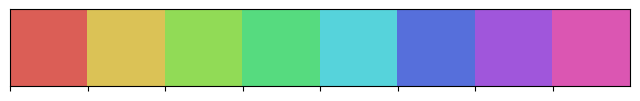

In [13]:
hls_colors = sns.color_palette("hls", NAM)
sns.palplot(hls_colors)

In [14]:
def readOzoneTemplatexy(ozoneName,
                      colLbda='LAMBDA', colTrans='OZONE', ext=1):
    """
    Read ozone transmission template, interpolate over
    wavelengthes, and convert to extinction [mag/airmass].

    :param ozoneName: input FITS table, with columns *colLbda*
      (wavelength in AA) and *colTrans* (fractional transmission), and
      key 'REFO3COL' specifing the reference ozone column density [DU]
    :param lbda: output wavelengthes [AA]
    :param colLbda: name of the wavelength (in AA) column
    :param colTrans: name of the ozone transmission column
    :param ext: extension in which to look for wavelength and
      transmission columns
    :return: ozone extinction [mag/airmass], refO3col
    """

    # Read wavelength and transmission columns
    ffile = F.open(ozoneName)
    x = ffile[ext].data.field(colLbda)   # Wavelength
    y = ffile[ext].data.field(colTrans)  # Transmission
    refO3col = ffile[ext].header["REFO3COL"]
    return x,y,refO3col


# Check emulator

In [15]:
Dict_Of_sitesPressures

{'LSST': 731.50433,
 'CTIO': 774.6052,
 'OHP': 937.22595,
 'PDM': 710.90637,
 'OMK': 600.17224,
 'OSL': 1013.0}

In [16]:
obs_str = 'LSST'
std_pressure = Dict_Of_sitesPressures[obs_str]
label = f"P = {std_pressure:.0f} hPa"

In [17]:
emul =  AtmEmulator(obs_str=obs_str)

Observatory LSST found in preselected observation sites


In [18]:
WL = emul.GetWL()

## PyExtinction

In [19]:
# be sure of the path of pyextinction ozone template
pyE_O3Template = '../../../src/pyextinction/o3data/ozoneTemplate.fits'

In [20]:
pyExt_model = ExtinctionModel(WL*10.)

In [21]:
pyE_press = 730
pyE_o3 = 600.
pyE_tau = 0.05
pyE_ang = 1.3
pyE_pars = np.array([pyE_press,pyE_o3,pyE_tau,pyE_ang])
pyE_label1='pyExt Rayleigh [%.0f mbar]' % pyE_press
pyE_label2='pyExt Ozone [%.0f DU]' % pyE_o3
pyE_label3=u'pyExt Aerosols [τ=%.4f, å=%.2f]' % (pyE_tau, pyE_ang)
pyE_all_labels = [pyE_label1,pyE_label2,pyE_label3]

In [22]:
pyExt_model.setParams(pyE_pars, dpars=None)
pyE_components_extinctions = pyExt_model.extinctionComponents()
pyE_opticalindexes = EXT2OPT * pyE_components_extinctions

In [23]:
pyE_xO3ref,pyE_yO3ref,pyE_refO3col = readOzoneTemplatexy(pyE_O3Template)
pyE_labelO3_ref = f"pyExt Ozone ref {pyE_refO3col} DU"

In [24]:
pyExt_model.__str__()

'Wavelength domain: 3000.0-11000.0 A by step of 10.0 A (800 px)\nOzone template: /Users/dagoret/MacOSX/GitHub/LSST/AtmosphericSimulation/AtmEmulator/src/pyextinction/o3data/ozoneTemplate.fits (265.0 DU)\nAerosol reference wavelength: 10000 A\nInput extinction parameters:\n  Pressure: 730 +/- 0 mbar\n  Ozone:    600 +/- 0 DU\n  Aerosols: optical depth @ refLbda: 0.05 +/- 0\n            angstrom exponent:         1.30 +/- 0.00\n'

## Check emulator with Rayleigh scattering

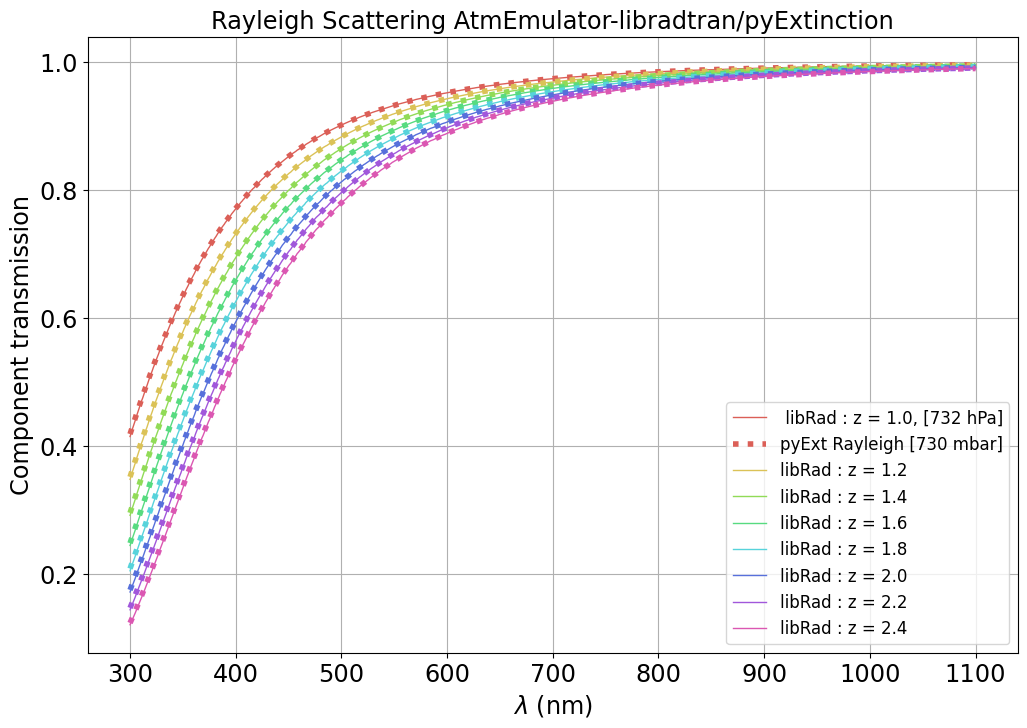

In [25]:
fig = plt.figure(figsize=(12,8))
ax=fig.add_subplot()
for idx,am in enumerate(airmasses):

    transm = emul.GetRayleighTransparencyArray(WL,am)
    if idx==0:
        label= f" libRad : z = {am:.1f}, [{std_pressure:.0f} hPa]"
    else:
        label = f"libRad : z = {am:.1f}"
    ax.plot(WL,transm,'-',color=hls_colors[idx],label=label,lw=1)
    if idx==0:
        ax.plot(WL,np.exp(-pyE_opticalindexes[0,:]*am),":",color=hls_colors[idx],lw=4,label=pyE_label1)
    else:
        ax.plot(WL,np.exp(-pyE_opticalindexes[0,:]*am),":",color=hls_colors[idx],lw=4)
ax.set_ylabel("Component transmission")
ax.set_xlabel("$\\lambda$ (nm)")
ax.legend()
ax.set_title("Rayleigh Scattering AtmEmulator-libradtran/pyExtinction")
ax.grid()

## Check emulator with Ozone absorption

- expect no difference

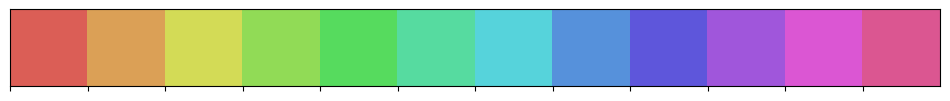

In [26]:
hls_colors = sns.color_palette("hls", NOZ)
sns.palplot(hls_colors)

In [27]:
pyE_pars = np.array([pyE_press,pyE_refO3col,pyE_tau,pyE_ang])
pyE_label1='pyExt Rayleigh [%.0f mbar]' % pyE_press
pyE_label2='pyExt Ozone [%.0f DU]' % pyE_refO3col
pyE_label3=u'pyExt Aerosols [τ=%.4f, å=%.2f]' % (pyE_tau, pyE_ang)
pyE_all_labels = [pyE_label1,pyE_label2,pyE_label3]
pyExt_model.setParams(pyE_pars, dpars=None)
pyE_components_extinctions = pyExt_model.extinctionComponents()
pyE_opticalindexes = EXT2OPT * pyE_components_extinctions

(0.8, 1.025)

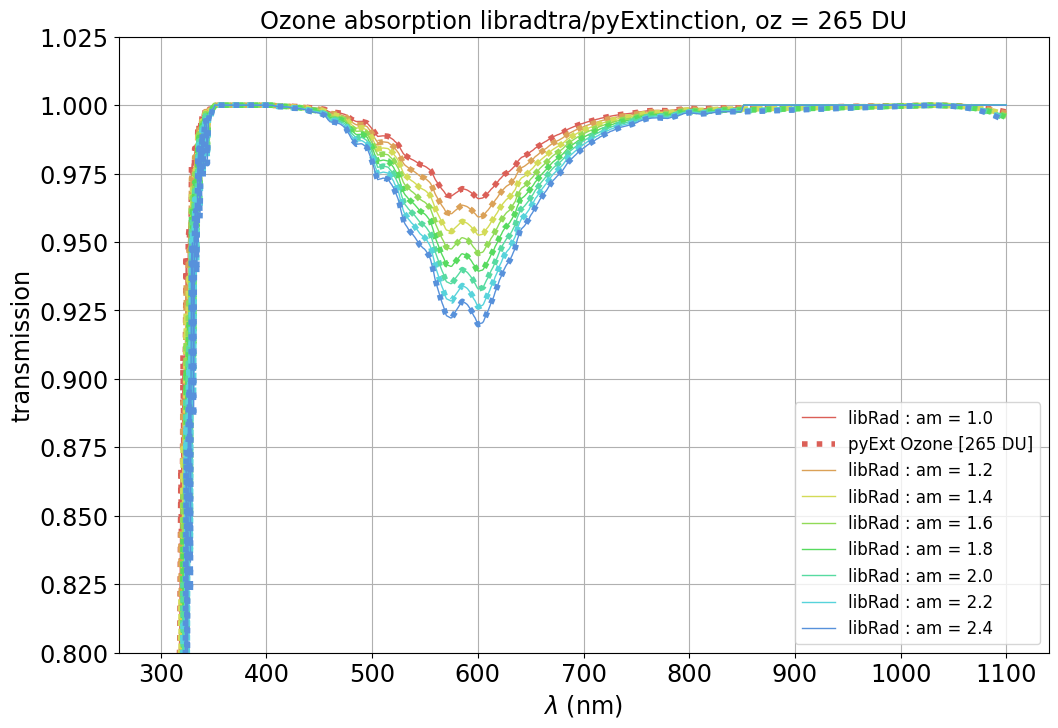

In [28]:
oz= pyE_refO3col
fig = plt.figure(figsize=(12,8))
ax=fig.add_subplot()

for idx,am in enumerate(airmasses):

    transm = emul.GetOZabsTransparencyArray(WL,am,oz)
    label = f"libRad : am = {am:.1f}"
    ax.plot(WL,transm,'-',color=hls_colors[idx],label=label,lw=1)

    if idx ==0:
        ax.plot(WL,np.exp(-pyE_opticalindexes[1,:]*am),':',color=hls_colors[idx],label=pyE_label2,lw=4)
    else:
        
        ax.plot(WL,np.exp(-pyE_opticalindexes[1,:]*am),':',color=hls_colors[idx],lw=4)

ax.set_ylabel("transmission")
ax.set_xlabel("$\\lambda$ (nm)")
ax.legend()
ax.set_title(f"Ozone absorption libradtra/pyExtinction, oz = {oz:.0f} DU")
ax.grid()
ax.set_ylim(0.8,1.025)


# Aerosols with One Component

### Parameters for pyExtinction

In [29]:
pyE_tau = 0.05
pyE_ang = 1.3

### Convert aerosols parameters for AtmEmulator

- not same reference wavelength


In [30]:
taus = [pyE_tau*(1000./550.)**pyE_ang ]
betas = [- pyE_ang]
ncomp=1

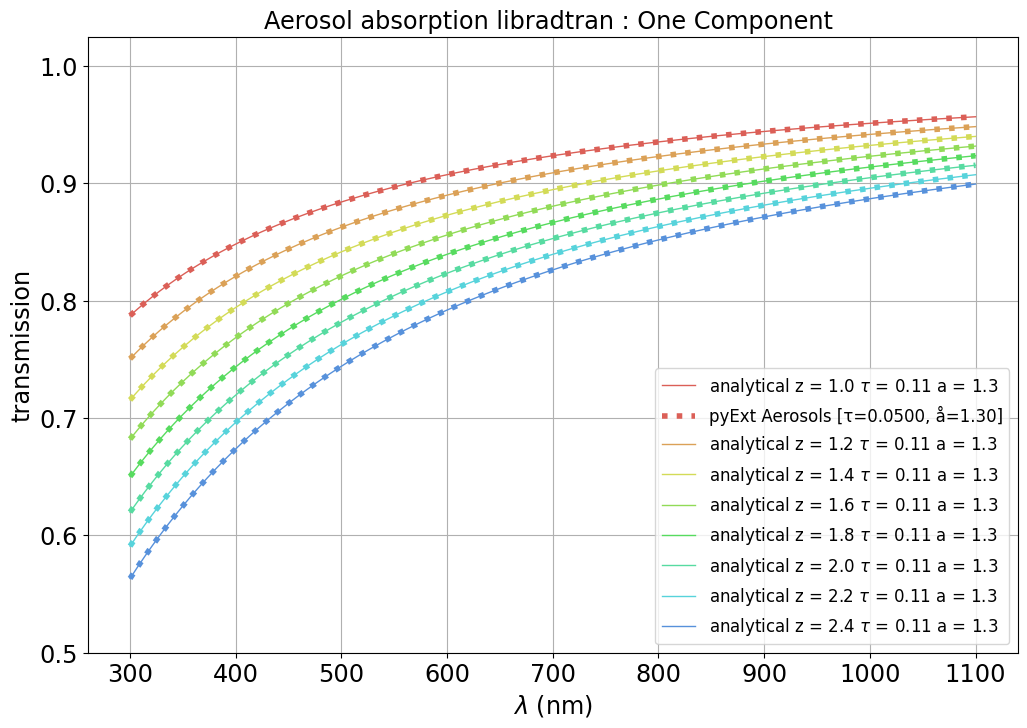

In [31]:
fig = plt.figure(figsize=(12,8))
ax=fig.add_subplot()

for idx,am in enumerate(airmasses):
    label = f"analytical z = {am:.1f} $\\tau$ = {taus[0]:.2f} a = {-betas[0]}"
    transm = emul.GetAerosolsTransparencies(WL,am,ncomp,taus,betas)
    ax.plot(WL,transm,"-",color=hls_colors[idx],label=label,lw=1)
    if idx==0:
        ax.plot(WL,np.exp(-pyE_opticalindexes[2,:]*am),":",color=hls_colors[idx],lw=4,label=pyE_label3) 
    else:
        ax.plot(WL,np.exp(-pyE_opticalindexes[2,:]*am),":",color=hls_colors[idx],lw=4) 
ax.set_ylim(0.5,1.025)
ax.set_ylabel("transmission")
ax.set_xlabel("$\\lambda$ (nm)")
ax.legend()
ax.set_title(f"Aerosol absorption libradtran : One Component ")
ax.grid()
